# Flamedisx benchmarking

### Common setup

In [2]:
#!nvidia-smi

In [3]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

File ‘_if_on_colab_setup_flamedisx.ipynb’ already there; not retrieving.

Flamedisx is installed :-)


In [4]:
import gc
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import flamedisx as fd
import tensorflow as tf

### Simulation benchmark

In [0]:
s = fd.ERSource()
n_trials = int(1e6)

In [0]:
%%timeit
#%%prun -D fd_simulation_.prof
s.simulate(n_trials)

1 loop, best of 3: 3.99 s per loop


In [0]:
1e6/1.43

699300.6993006993

In [0]:
del s
gc.collect()

125

February 1, Jelle's laptop: 7.0e5 events/sec (1M events = 1.42 sec)

Reproduced 23 March (in optimizations branch)

For comparison, drawing just a single binomial sample:

In [0]:
%%timeit
np.random.binomial(100, 0.1, size=n_trials)

10 loops, best of 3: 88.9 ms per loop


In [0]:
n_trials/87e-3

11494252.873563219

February 1, Jelle's laptop: 16M events/sec (1M events = 0.06 sec)

March 23, colab CPU: 9.7M events/sec (1M events = 0.1 sec)

colab CPU on GPU runtime: 11M events/sec (1M events = 87 msec)

### Hist ll cost

at least 70 bins cS1 (so binning < than PMT resolution), ER/NR disc on level of few * 1e-3 

-> need O(10^6) events / cS1 bin to get error comparable to that 

-> need O(10^7 - 10^8) events to properly sample the ER histogram

-> single histogram takes O(10 - 100) seconds to compute.

In [6]:
import pickle
with open('benchmarks_1000evts_hessian_trust.pkl', mode='rb') as f:
    q = pickle.load(f)
    n_datasets = q['n_datasets']
    max_order = q['max_order']
    datasets = q['datasets']
    n_coeffs_range = q['n_coeffs_range']
    t_fit = q['t_fit']
    t_init = q['t_init']
    t_set_data = q['t_set_data']

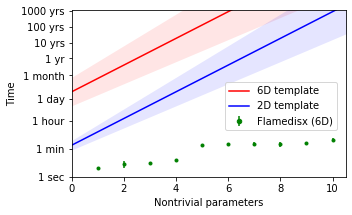

In [36]:
# k rbins, k zbins, k tbins, k^N_nuisance template
def cost_hours(n_nuisance=5, k=5, single_hist_sec=100, twod=False):
    n = n_nuisance
    if not twod:
        n = n_nuisance + 4
    return single_hist_sec * k**n / 3600

n_nuisance = np.arange(11 + 1)

from scipy.constants import golden_ratio
plt.figure(figsize=(5, 5/golden_ratio))

for twod, color, label in [
        (False, 'r', '6D template'),
        (True, 'b', '2D template')]:
    plt.fill_between(n_nuisance, 
                     cost_hours(n_nuisance, k=5, twod=twod, single_hist_sec=50),
                     cost_hours(n_nuisance, k=10, twod=twod, single_hist_sec=200),
                     alpha=0.1, color=color, linewidth=0)
    plt.plot(n_nuisance, 
             cost_hours(n_nuisance, k=7, twod=twod),
             color=color,
             label=label)
    
plt.errorbar(n_coeffs_range, 
             t_fit.mean(axis=1)/3600,  # t_fit is in seconds, plot is in hours
             yerr=t_fit.std(axis=1, ddof=1)/3600,  
             color='g', linestyle='', marker='.',
             label='Flamedisx (6D)')

plt.yscale('log')
plt.ylim(1e-2, 1e7)
#plt.ylim(0, 1000)
plt.xlim(0, n_nuisance.max()-0.5)
#plt.axhline(24 * 365.25, c='k', linestyle='--')
yr_h = 24 * 365.25
plt.yticks([1/3600, 1/60, 1, 24, yr_h/12, yr_h, yr_h * 10, yr_h * 100, yr_h * 1000],
           ['1 sec', '1 min', '1 hour', '1 day', '1 month', '1 yr', '10 yrs', '100 yrs', '1000 yrs'])

plt.legend(loc=(0.56, 0.28), frameon=True, 
           markerscale=1.5)
plt.xlabel("Nontrivial parameters")
plt.ylabel("Time")
plt.tight_layout()
plt.subplots_adjust(wspace=0)
#plt.savefig('fd_fit_benchmark.png', dpi=200, bbox_inches='tight')
plt.savefig('fd_fit_benchmark.pdf', bbox_inches='tight')

## Fd ll cost

In [0]:
class MyERSource(fd.ERSource):

    @staticmethod
    def p_electron(nq, 
                   c0=0.40, 
                   c1=-0.25, 
                   c2=0.1, 
                   c3=0.,
                   c4=0.,
                   c5=0.,
                   c6=0.,
                   c7=0.,
                   c8=0.,
                   c9=0.,
                   nq0=365.):
        x = fd.tf_log10(nq / nq0 + 1e-9)
        x = tf.dtypes.cast(x, dtype=fd.float_type())
        return fd.safe_p(
            c9 * x**9
            + c8 * x**8
            + c7 * x**7
            + c6 * x**6
            + c5 * x**5
            + c4 * x**4
            + c3 * x**3
            + c2 * x**2 
            + c1 * x 
            + c0)

n_datasets = 5        
datasets = [MyERSource().simulate(1000) for _ in range(n_datasets)]

c_ranges = {
    0: (0.35, 0.45, 2),
    1: (-0.5, -0.1, 2),
    2: (0.01, 0.5, 2),
}

In [0]:
def get_ll(n_coeffs):
    ll = fd.LogLikelihood(
            sources=dict(er=MyERSource),
            batch_size=10,
            data=datasets[0][:1],   # only need one event for this
            # TODO: option to skip precomputation!
            free_rates=('er',),
            **{'c' + str(i): c_ranges.get(i, (-0.5, 0.5, 2))
               for i in range(n_coeffs)}
        )
    ll.log_likelihood(second_order=True)  # Ensure all tracing has happened
    return ll
    
ll = get_ll(4)

Estimating mus: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


In [0]:
ll.set_data(datasets[1])

In [0]:
%%timeit
ll.log_likelihood()

1 loop, best of 3: 36.9 s per loop


In [0]:

%%timeit
ll.log_likelihood()

1 loop, best of 3: 41.3 s per loop


In [0]:
1000/120

8.333333333333334

In [0]:

315

In [0]:
max_order = 10
n_coeffs_range = np.arange(1, max_order + 1)
t_fit = np.zeros((max_order, n_datasets))
t_init = np.zeros(max_order)
t_single = np.zeros((max_order, n_datasets))
t_set_data = np.zeros((max_order, n_datasets))

for _nc_i, n_coeffs in enumerate(n_coeffs_range):
    t0 = time.time()
    ll = fd.LogLikelihood(
        sources=dict(er=MyERSource),
        batch_size=100,
        data=datasets[0][:1],   # only need one event for this
        # TODO: option to skip precomputation!
        #free_rates=('er',),
        **{'c' + str(i): c_ranges.get(i, (-0.5, 0.5, 2))
        for i in range(n_coeffs)})
    ll.log_likelihood(second_order=True)  # Ensure all tracing has happened
    t_init[_nc_i] = t = time.time() - t0
    print(f"Initialization with {n_coeffs} parameters took {t:.2f} sec")


    for data_i, data in enumerate(datasets):
        t0 = time.time()
        ll.set_data(data)
        t_set_data[_nc_i, data_i] = t = time.time() - t0
        print(f"set_data with {n_coeffs} parameters took {t:.2f} sec")

        t0 = time.time()
        bf = ll.bestfit(#guess=dict(er_rate_multiplier=0.0011 * len(data)),
                        #optimizer_kwargs=dict(method='tnc'),
                        #optimizer='minuit'
                        )
        t_fit[_nc_i, data_i] = t = time.time() - t0
        print(f"Fitting with {n_coeffs} parameters took {t:.2f} sec")

    print("\n")
    del ll
    gc.collect()


Estimating mus: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Initialization with 1 parameters took 13.28 sec
set_data with 1 parameters took 0.05 sec
Fitting with 1 parameters took 1.63 sec
set_data with 1 parameters took 0.04 sec
Fitting with 1 parameters took 2.06 sec
set_data with 1 parameters took 0.04 sec
Fitting with 1 parameters took 2.05 sec
set_data with 1 parameters took 0.04 sec
Fitting with 1 parameters took 1.55 sec
set_data with 1 parameters took 0.04 sec
Fitting with 1 parameters took 2.07 sec




Estimating mus: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Initialization with 2 parameters took 11.94 sec
set_data with 2 parameters took 0.04 sec
Fitting with 2 parameters took 3.97 sec
set_data with 2 parameters took 0.04 sec
Fitting with 2 parameters took 3.15 sec
set_data with 2 parameters took 0.04 sec
Fitting with 2 parameters took 3.03 sec
set_data with 2 parameters took 0.04 sec
Fitting with 2 parameters took 3.00 sec
set_data with 2 parameters took 0.04 sec
Fitting with 2 parameters took 3.12 sec




Estimating mus: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Initialization with 3 parameters took 12.64 sec
set_data with 3 parameters took 0.04 sec
Fitting with 3 parameters took 6.12 sec
set_data with 3 parameters took 0.04 sec
Fitting with 3 parameters took 5.21 sec
set_data with 3 parameters took 0.04 sec
Fitting with 3 parameters took 4.08 sec
set_data with 3 parameters took 0.04 sec
Fitting with 3 parameters took 4.16 sec
set_data with 3 parameters took 0.04 sec
Fitting with 3 parameters took 3.18 sec




Estimating mus: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Initialization with 4 parameters took 13.64 sec
set_data with 4 parameters took 0.04 sec
Fitting with 4 parameters took 6.32 sec
set_data with 4 parameters took 0.04 sec
Fitting with 4 parameters took 3.69 sec
set_data with 4 parameters took 0.04 sec
Fitting with 4 parameters took 6.58 sec
set_data with 4 parameters took 0.04 sec
Fitting with 4 parameters took 6.54 sec
set_data with 4 parameters took 0.04 sec
Fitting with 4 parameters took 7.66 sec




Estimating mus: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Initialization with 5 parameters took 15.26 sec
set_data with 5 parameters took 0.04 sec
Fitting with 5 parameters took 67.32 sec
set_data with 5 parameters took 0.04 sec
Fitting with 5 parameters took 70.56 sec
set_data with 5 parameters took 0.04 sec
Fitting with 5 parameters took 71.30 sec
set_data with 5 parameters took 0.04 sec
Fitting with 5 parameters took 48.64 sec
set_data with 5 parameters took 0.04 sec
Fitting with 5 parameters took 75.65 sec




Estimating mus: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Initialization with 6 parameters took 16.75 sec
set_data with 6 parameters took 0.04 sec
Fitting with 6 parameters took 81.18 sec
set_data with 6 parameters took 0.05 sec
Fitting with 6 parameters took 72.68 sec
set_data with 6 parameters took 0.04 sec
Fitting with 6 parameters took 88.54 sec
set_data with 6 parameters took 0.05 sec
Fitting with 6 parameters took 66.70 sec
set_data with 6 parameters took 0.04 sec
Fitting with 6 parameters took 74.35 sec




Estimating mus: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Initialization with 7 parameters took 19.02 sec
set_data with 7 parameters took 0.05 sec
Fitting with 7 parameters took 76.81 sec
set_data with 7 parameters took 0.04 sec
Fitting with 7 parameters took 97.68 sec
set_data with 7 parameters took 0.04 sec
Fitting with 7 parameters took 85.30 sec
set_data with 7 parameters took 0.05 sec
Fitting with 7 parameters took 160.36 sec
set_data with 7 parameters took 0.04 sec
Fitting with 7 parameters took 100.35 sec




Estimating mus: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Initialization with 8 parameters took 20.72 sec
set_data with 8 parameters took 0.04 sec
Fitting with 8 parameters took 83.89 sec
set_data with 8 parameters took 0.04 sec
Fitting with 8 parameters took 86.38 sec
set_data with 8 parameters took 0.04 sec
Fitting with 8 parameters took 115.36 sec
set_data with 8 parameters took 0.04 sec
Fitting with 8 parameters took 67.26 sec
set_data with 8 parameters took 0.05 sec
Fitting with 8 parameters took 77.47 sec




Estimating mus: 100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Initialization with 9 parameters took 22.61 sec
set_data with 9 parameters took 0.05 sec
Fitting with 9 parameters took 120.58 sec
set_data with 9 parameters took 0.05 sec
Fitting with 9 parameters took 92.86 sec
set_data with 9 parameters took 0.04 sec
Fitting with 9 parameters took 124.81 sec
set_data with 9 parameters took 0.04 sec
Fitting with 9 parameters took 106.06 sec
set_data with 9 parameters took 0.04 sec
Fitting with 9 parameters took 97.87 sec




Estimating mus: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Initialization with 10 parameters took 24.44 sec
set_data with 10 parameters took 0.04 sec
Fitting with 10 parameters took 123.15 sec
set_data with 10 parameters took 0.05 sec
Fitting with 10 parameters took 149.13 sec
set_data with 10 parameters took 0.04 sec
Fitting with 10 parameters took 152.53 sec
set_data with 10 parameters took 0.04 sec
Fitting with 10 parameters took 96.03 sec
set_data with 10 parameters took 0.04 sec
Fitting with 10 parameters took 118.63 sec




In [0]:
import pickle
with open('benchmarks_1000evts_hessian_trust_2.pkl', mode='wb') as f:
    pickle.dump(
        dict(
            n_datasets=n_datasets,
            max_order=max_order,

            datasets=datasets,

            n_coeffs_range=n_coeffs_range,
            t_fit=t_fit,
            t_init=t_init,
            t_set_data=t_set_data), 
        f)

# Old stuff

<ErrorbarContainer object of 3 artists>

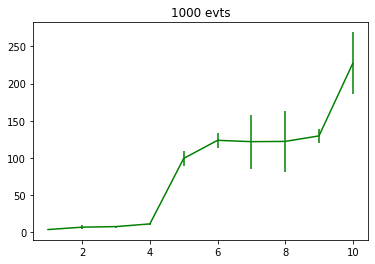

In [0]:

plt.title('1000 evts')
plt.errorbar(n_coeffs_range, 
             t_fit.mean(axis=1), 
             yerr=t_fit.std(axis=1, ddof=1),
             color='g', 
             label='6D, flamedisx')
#plt.plot(n_coeffs_range, t_init, marker='.')

<ErrorbarContainer object of 3 artists>

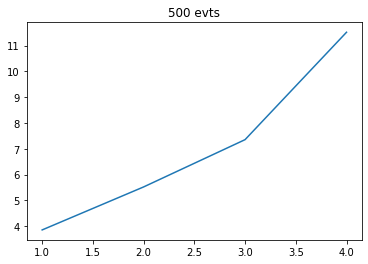

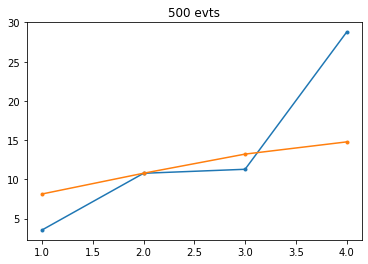

In [0]:

plt.title('500 evts')
plt.plot(n_coeffs_range, t_fit, marker='.')
plt.plot(n_coeffs_range, t_init, marker='.')

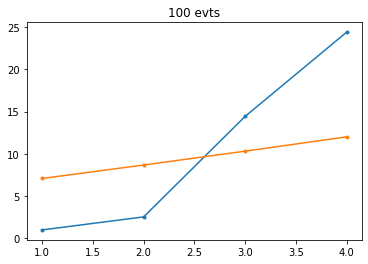

In [0]:
plt.title('100 evts')
plt.plot(n_coeffs_range, t_fit, marker='.')
plt.plot(n_coeffs_range, t_init, marker='.')

In [0]:
# 100 events, fit time only. 
n_coeffs_range, results

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([  1.13471746,   1.88248491,  21.33644128,  34.91656089,
         29.98408008,  38.16339254,  52.54934001,  66.83897233,
         76.93696642, 116.23193955]))

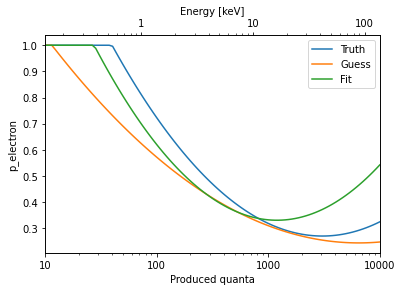

In [0]:
def plot_nq(s_class=fd.ERSource, plot_kwargs=None, twin=True, 
            # Eat params we don't need...
            er_rate_multiplier=None, elife=None, g2=None,
            **params):
    if plot_kwargs is None:
        plot_kwargs = dict()
    nq = np.logspace(1, 4, 100)
    
    plt.plot(nq, s_class.p_electron(nq, **params), **plot_kwargs)
    plt.xlabel('Produced quanta')
    plt.ylabel('p_electron')
    plt.xlim(10, 1e4)
    plt.xscale('log')
    ax = plt.gca()
    
    if twin:
        ax2 = plt.twiny()
        ax2.set_xscale('log')
        ax2.set_xlim(*np.array(ax.get_xlim()) * fd.ERSource.work)
        ax2.set_xlabel("Energy [keV]")

    for x in [ax] + ([ax2] if twin else []):
        x.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.sca(ax)
        
plot_nq(plot_kwargs=dict(label='Truth'))
plot_nq(MyERSource, plot_kwargs=dict(label='Guess'), twin=False)
plot_nq(MyERSource, plot_kwargs=dict(label='Fit'), twin=False, **bf)
plt.legend(loc='upper right')

In [0]:
ll.summary(bf)

er_rate_multiplier: 0.0107 +- 0.00254
a: 0.813 +- 0.546
b: -0.201 +- 0.0959
c: 0.325 +- 0.0271
Correlation matrix:
                    er_rate_multiplier      a      b      c
er_rate_multiplier               1.000  0.024 -0.062  0.009
a                                0.024  1.000 -0.386 -0.724
b                               -0.062 -0.386  1.000 -0.142
c                                0.009 -0.724 -0.142  1.000
